In [13]:
import copy
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch
%matplotlib inline

import matplotlib.pyplot as plt
import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample

from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from src.model.loss import spectral_loss
from synth.synth_architecture import SynthModular
# from config import SynthConfig
from src.main_hp_search_dec_only import configure_experiment

# from config import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants

import matplotlib
# %matplotlib inline
# matplotlib.use('TkAgg')

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Setup experiment

exp_name = 'del_visualization'
dataset_name = 'fm_saw_single'
config_name = r'C:\Users\noamk\PycharmProjects\ai_synth\configs\lfo_saw_single_synth_config_hp_search.yaml'
device = 'cuda'
# resample_op = Resample(orig_freq=16000, new_freq=50).to('cpu')

cfg = configure_experiment(exp_name, dataset_name, config_name, debug=True)

# synth = SynthModular(synth_cfg=synth_cfg, sample_rate=cfg.sample_rate, device=device, num_sounds=1,
#                      signal_duration_sec=cfg.signal_duration_sec, preset=synth_cfg.preset)
synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

# dataset = AiSynthDataset(cfg.train_parameters_file, cfg.train_audio_dir, device)
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)



Deleting previous experiment...


In [3]:
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)

target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(1, 1): {'operation': 'lfo', 'parameters': {'active': True, 'output': [(0, 2)], 'freq': 0.7984751672891355, 'waveform': 'square'}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': True, 'active': True, 'amp_c': 0.6271676093063665, 'freq_c': 277.18263097687196, 'mod_index': 0.09726261649881028}}}


In [4]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants, device=device)

In [5]:
loss_handler.spectrogram_ops

{'2048_spectrogram': Spectrogram(),
 '1024_spectrogram': Spectrogram(),
 '512_spectrogram': Spectrogram(),
 '256_spectrogram': Spectrogram(),
 '128_spectrogram': Spectrogram(),
 '64_spectrogram': Spectrogram()}

In [23]:
fm_freq_vals = np.linspace(0, 1200, 1200)

losses1 = []
for freq_val in fm_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'freq_c': freq_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses1.append(loss_val.detach().cpu().numpy().item())

print(losses1)


[7.335923194885254, 7.323550224304199, 7.300155162811279, 7.258660793304443, 7.216069221496582, 7.181387424468994, 7.132969856262207, 7.041886806488037, 6.963064670562744, 6.933760643005371, 6.861929416656494, 6.774298667907715, 6.663900375366211, 6.573049545288086, 6.445055961608887, 6.411123752593994, 6.5308518409729, 6.636192321777344, 6.71113920211792, 6.824895858764648, 6.865221977233887, 6.950372695922852, 7.023318767547607, 7.076640605926514, 7.129459857940674, 7.174803256988525, 7.192576885223389, 7.225632667541504, 7.283116340637207, 7.2779059410095215, 7.288524627685547, 7.292003631591797, 7.313292980194092, 7.363733768463135, 7.333619594573975, 7.343121528625488, 7.363974571228027, 7.380485534667969, 7.417043209075928, 7.37339448928833, 7.385334014892578, 7.396605014801025, 7.3897504806518555, 7.408927917480469, 7.393187046051025, 7.403631210327148, 7.418972969055176, 7.4231767654418945, 7.453542709350586, 7.470365047454834, 7.447755336761475, 7.4348649978637695, 7.433516502

In [9]:
matplotlib.use('TkAgg')



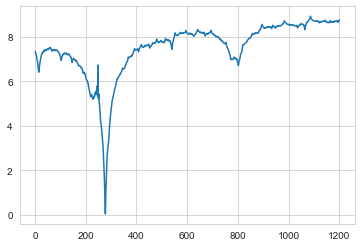

In [24]:

plt.plot(fm_freq_vals, losses1)
plt.show()

In [25]:
lfo_freq_vals = np.linspace(0, 15, 100)

losses2 = []
for freq_val in lfo_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(1, 1)]['parameters'].update({'freq': freq_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses2.append(loss_val.detach().cpu().numpy().item())

print(losses2)

[7.323907375335693, 1.4417402744293213, 1.4417402744293213, 1.4417402744293213, 1.1059386730194092, 0.2187301367521286, 0.6376710534095764, 1.4330167770385742, 1.820888638496399, 1.9512025117874146, 2.061028003692627, 2.0489768981933594, 2.2226719856262207, 2.4674785137176514, 2.5404012203216553, 2.700110912322998, 2.685533285140991, 2.6835474967956543, 2.786067485809326, 2.8216893672943115, 2.8515989780426025, 2.8866069316864014, 2.839818000793457, 3.0680179595947266, 3.021651029586792, 3.0399391651153564, 3.0290780067443848, 3.179626941680908, 3.146164655685425, 2.9932756423950195, 3.0908656120300293, 3.115504264831543, 3.2427802085876465, 3.2784242630004883, 3.2978811264038086, 3.3091564178466797, 3.3461451530456543, 3.27541184425354, 3.1685757637023926, 3.6509976387023926, 3.485020160675049, 3.4920730590820312, 3.5130810737609863, 3.5202648639678955, 3.5276708602905273, 3.551837682723999, 3.5450735092163086, 3.485905170440674, 3.5450992584228516, 3.5260238647460938, 3.5161576271057

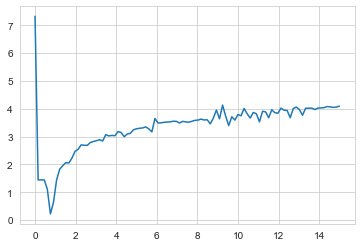

In [26]:
plt.plot(lfo_freq_vals, losses2)

plt.show()

In [27]:
amp_vals = np.linspace(0, 1, 100)

losses3 = []
for amp_val in amp_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'amp_c': amp_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses3.append(loss_val.detach().cpu().numpy().item())

print(losses3)


[4.903559684753418, 4.90228796005249, 4.898471832275391, 4.8921122550964355, 4.883208274841309, 4.871760845184326, 4.857769012451172, 4.841233730316162, 4.8221540451049805, 4.800530910491943, 4.776363372802734, 4.749652862548828, 4.720397472381592, 4.688598155975342, 4.654255390167236, 4.617368698120117, 4.577937602996826, 4.53596305847168, 4.491444110870361, 4.4443817138671875, 4.394775390625, 4.342624664306641, 4.287930011749268, 4.230691909790039, 4.170910358428955, 4.108583927154541, 4.0437140464782715, 3.976300001144409, 3.9063425064086914, 3.8338403701782227, 3.7587943077087402, 3.6812050342559814, 3.601071357727051, 3.5183939933776855, 3.4331724643707275, 3.345407247543335, 3.2550978660583496, 3.1622447967529297, 3.066847801208496, 2.968906879425049, 2.8684215545654297, 2.765392780303955, 2.6598198413848877, 2.5517032146453857, 2.44104266166687, 2.3278379440307617, 2.212089776992798, 2.093797206878662, 1.9729608297348022, 1.8495807647705078, 1.7236570119857788, 1.595188736915588

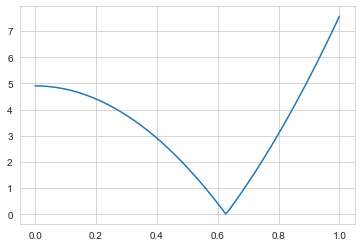

In [28]:
plt.plot(amp_vals, losses3)
plt.show()

In [29]:
mod_index_vals = np.linspace(0, 0.3, 1000)

losses4 = []
for mod_index_val in mod_index_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'mod_index': mod_index_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses4.append(loss_val.detach().cpu().numpy().item())

print(losses4)

[7.323907375335693, 7.327574729919434, 7.336111068725586, 7.342756748199463, 7.352214336395264, 7.359969139099121, 7.349048614501953, 7.34799861907959, 7.358858585357666, 7.358378887176514, 7.358555316925049, 7.377353668212891, 7.339999198913574, 7.323546409606934, 7.322988986968994, 7.308727264404297, 7.296316623687744, 7.289242744445801, 7.293490409851074, 7.2524943351745605, 7.251821517944336, 7.283945083618164, 7.311946868896484, 7.332058906555176, 7.36129903793335, 7.414772033691406, 7.392131328582764, 7.391687393188477, 7.393889904022217, 7.400500774383545, 7.412978172302246, 7.439939498901367, 7.477996826171875, 7.485318660736084, 7.487231254577637, 7.492478847503662, 7.508613109588623, 7.500194549560547, 7.506321430206299, 7.526527404785156, 7.554455280303955, 7.529074668884277, 7.516876220703125, 7.51134729385376, 7.499765872955322, 7.491818428039551, 7.482120990753174, 7.478187084197998, 7.4767680168151855, 7.434820175170898, 7.435732364654541, 7.450282096862793, 7.4777078628

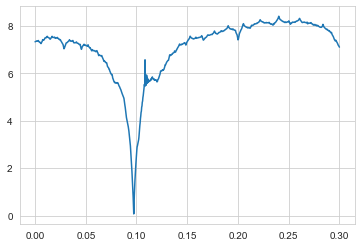

In [30]:
plt.plot(mod_index_vals, losses4)
plt.show()

In [8]:
sim_target_params = {'freq_c'}

In [9]:
spec_op = Spectrogram(n_fft=512)


fig, ax = plt.subplots(1, 2, figsize=(80, 40))

target_spec = spec_op(target_signal.cpu())

update_params = copy.deepcopy(target_param_dict)

update_params[(0,1)]['parameters'].update({'freq_c': 200})
synth.update_cells_from_dict(update_params)
signal, _ = synth.generate_signal()

pred_spec = spec_op(signal.cpu().detach())

ax[0].imshow(target_spec.squeeze(), origin='lower')
ax[1].imshow(pred_spec.squeeze(), origin='lower')

KeyError: (0, 1)